# Relative Intensity (RI) and ROC for Earthquake Analysis

At first, we import datasets to Dataframe.

In [1]:
import numpy as np
import pandas as pd
import glob

PATH = './All/*.csv'
data = pd.concat(map(pd.read_csv, glob.glob(PATH)))
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93203 entries, 0 to 1044
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         93203 non-null  object
 1   Time         93203 non-null  object
 2   震央地名         93203 non-null  object
 3   Lat          93203 non-null  object
 4   Long         93203 non-null  object
 5   Depth        93203 non-null  int64 
 6   M            93203 non-null  object
 7   最大震度         93203 non-null  object
 8   Source.Name  89371 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.1+ MB
None


For analyzation, we use only date, time, position, depth and magnitude.

In [2]:
data = data[['Date', 'Time', 'Lat', 'Long', 'Depth', 'M']]
data = data.replace(to_replace="不明",value="NaN")
data['M'] = data['M'].astype(np.float64)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85334 entries, 0 to 1044
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    85334 non-null  object 
 1   Time    85334 non-null  object 
 2   Lat     85334 non-null  object 
 3   Long    85334 non-null  object 
 4   Depth   85334 non-null  int64  
 5   M       85334 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.6+ MB


As you can see, latitude and longitude of the positions are not in decimal. For analyzation, we have to convert from dms to decimal.

In [3]:
import re
def dms2dd(s):
    degrees, minutes, direction = re.split('[°\']+', s)
    dd = float(degrees) + float(minutes)/60
    return dd

Apply dms2dd function to the dataframe

In [4]:
data['Lat'] = data['Lat'].apply(dms2dd)
data['Long'] = data['Long'].apply(dms2dd)

In some places, the data is incorrect or unusable, so we have to remove all of these. After removing, we have to check the amount of data for analyzation. After conversion, we have to cast the data to be float.

In [5]:
import numpy as np
data = data.astype({'Lat': np.float64, 'Long': np.float64, 'M': np.float64, 'Depth': np.float64})
data.drop(data[data['M']<5].index, inplace=True)
data = data.reset_index()
data = data[['Date', 'Time', 'Lat', 'Long', 'Depth', 'M']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    229 non-null    object 
 1   Time    229 non-null    object 
 2   Lat     229 non-null    float64
 3   Long    229 non-null    float64
 4   Depth   229 non-null    float64
 5   M       229 non-null    float64
dtypes: float64(4), object(2)
memory usage: 10.9+ KB


# Convert 'Date' and 'Time' to Timestamp

At first, we have to use array to store the Timestamp after convert from 'Date' and 'Time'.

In [6]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # if the date and time cannot be converted
        timestamp.append('ValueError')

Insert Timestamp to dataframe

In [7]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

As you can see above, the data in dataframe is not in order by time, so we have to reorder it. We also have to remove the Timestamp Error

In [8]:
data = data[data.Timestamp != 'ValueError']
data.sort_values(by='Timestamp', inplace=True)
data.head()

,Date,Time,Lat,Long,Depth,M,Timestamp
69,1/9/2000,13:02:22,37.290000,141.663333,43.0,5.1,947390542.0
68,1/11/2000,1:40:45,27.493333,140.606667,469.0,5.8,947522445.0
67,1/23/2000,16:40:02,30.238333,131.056667,18.0,5.4,948613202.0
66,1/28/2000,23:21:09,43.006667,146.743333,59.0,7.0,949069269.0
65,1/29/2000,1:39:25,26.130000,124.560000,164.0,5.9,949077565.0


In [9]:
data.info

<bound method DataFrame.info of            Date      Time        Lat        Long  Depth    M     Timestamp
69     1/9/2000  13:02:22  37.290000  141.663333   43.0  5.1  9.473905e+08
68    1/11/2000   1:40:45  27.493333  140.606667  469.0  5.8  9.475224e+08
67    1/23/2000  16:40:02  30.238333  131.056667   18.0  5.4  9.486132e+08
66    1/28/2000  23:21:09  43.006667  146.743333   59.0  7.0  9.490693e+08
65    1/29/2000   1:39:25  26.130000  124.560000  164.0  5.9  9.490776e+08
..          ...       ...        ...         ...    ...  ...           ...
224   3/27/2011  19:23:20  35.313333  141.163333   31.0  5.0  1.301221e+09
228   3/30/2011   1:35:44  39.653333  143.781667    8.0  5.6  1.301417e+09
71    6/30/2011   8:16:37  36.188333  137.953333    4.0  5.4  1.309389e+09
72   10/10/2011  11:45:57  37.506667  141.485000   47.0  5.6  1.318215e+09
70    4/19/2016  17:52:14  32.535000  130.635000   10.0  5.5  1.461056e+09

[229 rows x 7 columns]>

# Import Study Area and split train and test sets

To define the area, we have to import study area to group the data.

In [10]:
study_area = pd.read_csv("./study_area_25km.csv")
study_area.head()

,Lat,Long
0,30.0,128.000000
1,30.0,128.226093
2,30.0,128.452186
3,30.0,128.678279
4,30.0,128.904372


split train and test sets

In [11]:
train_test_ratio = 0.7
train_size = int(len(data)*train_test_ratio)
cbs = np.zeros(len(study_area))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
result = study_area.assign(RI=0)

# Calculate the RI in Study Area

In [12]:
from haversine import haversine
import math

r = 50
for i in range(len(study_area)):
    if i%100==0:
        print("pt. "+str(i)+" out of "+str(len(study_area))+" points")
    sr_energy = 0
    study_area_coord = (study_area["Lat"].values[i], study_area["Long"].values[i])
    for j in range(len(train_data)):
        eq_coord = (train_data["Lat"].values[j], train_data["Long"].values[j])
        dis = haversine(study_area_coord, eq_coord)
        if(r>=dis):
            sr_energy += math.e**(5.24+(1.44*train_data["M"].values[j]))
    cbs[i] = math.sqrt(sr_energy)

pt. 0 out of 5680 points
pt. 100 out of 5680 points
pt. 200 out of 5680 points
pt. 300 out of 5680 points
pt. 400 out of 5680 points
pt. 500 out of 5680 points
pt. 600 out of 5680 points
pt. 700 out of 5680 points
pt. 800 out of 5680 points
pt. 900 out of 5680 points
pt. 1000 out of 5680 points
pt. 1100 out of 5680 points
pt. 1200 out of 5680 points
pt. 1300 out of 5680 points
pt. 1400 out of 5680 points
pt. 1500 out of 5680 points
pt. 1600 out of 5680 points
pt. 1700 out of 5680 points
pt. 1800 out of 5680 points
pt. 1900 out of 5680 points
pt. 2000 out of 5680 points
pt. 2100 out of 5680 points
pt. 2200 out of 5680 points
pt. 2300 out of 5680 points
pt. 2400 out of 5680 points
pt. 2500 out of 5680 points
pt. 2600 out of 5680 points
pt. 2700 out of 5680 points
pt. 2800 out of 5680 points
pt. 2900 out of 5680 points
pt. 3000 out of 5680 points
pt. 3100 out of 5680 points
pt. 3200 out of 5680 points
pt. 3300 out of 5680 points
pt. 3400 out of 5680 points
pt. 3500 out of 5680 points
pt. 

show the result and insert RI to dataframe

In [13]:
result["RI"] = cbs/max(cbs)
print(result.to_string())

            Lat        Long        RI
0     30.000000  128.000000  0.000000
1     30.000000  128.226093  0.000000
2     30.000000  128.452186  0.000000
3     30.000000  128.678279  0.000000
4     30.000000  128.904372  0.000000
5     30.000000  129.130465  0.000000
6     30.000000  129.356558  0.000000
7     30.000000  129.582651  0.000000
8     30.000000  129.808743  0.000000
9     30.000000  130.034836  0.000000
10    30.000000  130.260929  0.000000
11    30.000000  130.487022  0.000000
12    30.000000  130.713115  0.142350
13    30.000000  130.939208  0.142350
14    30.000000  131.165301  0.142350
15    30.000000  131.391394  0.142350
16    30.000000  131.617487  0.000000
17    30.000000  131.843580  0.000000
18    30.000000  132.069673  0.000000
19    30.000000  132.295766  0.000000
20    30.000000  132.521859  0.000000
21    30.000000  132.747952  0.000000
22    30.000000  132.974045  0.000000
23    30.000000  133.200137  0.000000
24    30.000000  133.426230  0.000000
25    30.000

# Calculate ROC

We define the function to calculate the ROC of each area

In [14]:
def roc(n):
    a, b, c, d = 0, 0, 0, 0
    for i in range(len(result)):
        if((result["RI"].values[i]>=n) and (pn_grid["pn"].values[i]==1)):
            a+=1
        elif((result["RI"].values[i]>=n) and (pn_grid["pn"].values[i]==0)):
            b+=1
        elif((result["RI"].values[i]<n) and (pn_grid["pn"].values[i]==1)):
            c+=1
        else:
            d+=1
    return (a*d-b*c)/((a+c)*(b+d))

In [15]:
pn_grid = study_area.assign(pn=0)
test_mag = 5.0

for i in range(len(pn_grid)):
    if i%100==0:
        print("pt. " + str(i) + " out of " + str(len(study_area)) + " points")
    study_area_coord = (study_area["Lat"].values[i], study_area["Long"].values[i])
    for j in range(len(test_data)):
        eq_coord = (test_data["Lat"].values[j], test_data["Long"].values[j])
        dis = haversine(study_area_coord, eq_coord)
        if((r >= dis) and (test_data["M"].values[j] > test_mag)):
            pn_grid["pn"].values[i] = 1
            break

pt. 0 out of 5680 points
pt. 100 out of 5680 points
pt. 200 out of 5680 points
pt. 300 out of 5680 points
pt. 400 out of 5680 points
pt. 500 out of 5680 points
pt. 600 out of 5680 points
pt. 700 out of 5680 points
pt. 800 out of 5680 points
pt. 900 out of 5680 points
pt. 1000 out of 5680 points
pt. 1100 out of 5680 points
pt. 1200 out of 5680 points
pt. 1300 out of 5680 points
pt. 1400 out of 5680 points
pt. 1500 out of 5680 points
pt. 1600 out of 5680 points
pt. 1700 out of 5680 points
pt. 1800 out of 5680 points
pt. 1900 out of 5680 points
pt. 2000 out of 5680 points
pt. 2100 out of 5680 points
pt. 2200 out of 5680 points
pt. 2300 out of 5680 points
pt. 2400 out of 5680 points
pt. 2500 out of 5680 points
pt. 2600 out of 5680 points
pt. 2700 out of 5680 points
pt. 2800 out of 5680 points
pt. 2900 out of 5680 points
pt. 3000 out of 5680 points
pt. 3100 out of 5680 points
pt. 3200 out of 5680 points
pt. 3300 out of 5680 points
pt. 3400 out of 5680 points
pt. 3500 out of 5680 points
pt. 

In [16]:
print(pn_grid.to_string())
pn_grid.to_csv('pn_grid.csv')

            Lat        Long  pn
0     30.000000  128.000000   0
1     30.000000  128.226093   0
2     30.000000  128.452186   0
3     30.000000  128.678279   0
4     30.000000  128.904372   0
5     30.000000  129.130465   0
6     30.000000  129.356558   0
7     30.000000  129.582651   0
8     30.000000  129.808743   0
9     30.000000  130.034836   0
10    30.000000  130.260929   0
11    30.000000  130.487022   0
12    30.000000  130.713115   0
13    30.000000  130.939208   0
14    30.000000  131.165301   0
15    30.000000  131.391394   0
16    30.000000  131.617487   0
17    30.000000  131.843580   0
18    30.000000  132.069673   0
19    30.000000  132.295766   0
20    30.000000  132.521859   0
21    30.000000  132.747952   0
22    30.000000  132.974045   0
23    30.000000  133.200137   0
24    30.000000  133.426230   0
25    30.000000  133.652323   0
26    30.000000  133.878416   0
27    30.000000  134.104509   0
28    30.000000  134.330602   0
29    30.000000  134.556695   0
30    30

After preparing the data, we calculate ROC

In [17]:
digit_num = 5
start_roc = 0
stop_roc = 1
max_roc = [0, 0]

for i in range(digit_num):
    n = start_roc
    while(n<=stop_roc):
        val = roc(n)
        if(val>=max_roc[1]):
            max_roc[0] = n
            max_roc[1] = val
            print(max_roc)
        n += (10**(-(i+1)))
        
    # new start and stop values
    start_roc = max_roc[0]-(10**(-(i+1)))
    stop_roc = max_roc[0]+(10**(-(i+1)))

print(max_roc)

[0, 0.0]
[0.1, 0.6878406843008321]
[0.01, 0.6878406843008321]
[0.02, 0.6878406843008321]
[0.03, 0.6878406843008321]
[0.04, 0.6878406843008321]
[0.05, 0.6878406843008321]
[0.060000000000000005, 0.6878406843008321]
[0.07, 0.6878406843008321]
[0.08, 0.6878406843008321]
[0.09, 0.6878406843008321]
[0.09999999999999999, 0.6878406843008321]
[0.09, 0.6878406843008321]
[0.091, 0.6878406843008321]
[0.092, 0.6878406843008321]
[0.093, 0.6878406843008321]
[0.094, 0.6878406843008321]
[0.095, 0.6878406843008321]
[0.096, 0.6878406843008321]
[0.097, 0.6878406843008321]
[0.098, 0.6878406843008321]
[0.099, 0.6878406843008321]
[0.1, 0.6878406843008321]
[0.101, 0.6878406843008321]
[0.10200000000000001, 0.6878406843008321]
[0.10300000000000001, 0.6878406843008321]
[0.10400000000000001, 0.6878406843008321]
[0.10500000000000001, 0.6878406843008321]
[0.10600000000000001, 0.6878406843008321]
[0.10500000000000001, 0.6878406843008321]
[0.10510000000000001, 0.6878406843008321]
[0.10520000000000002, 0.6878406843008

/Users/phongwitsrikokcharoen/miniconda3/envs/earthquake/lib/python3.10/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


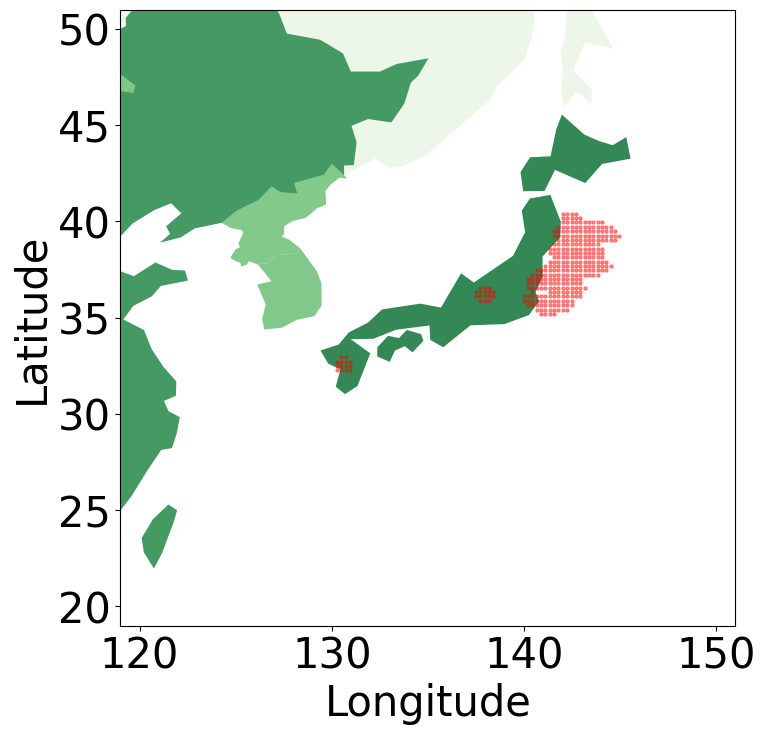

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.to_crs({'init':'epsg:4326'})

limx = [119, 151]
limy = [19, 51]
fig, ax = plt.subplots(figsize=(14, 8))
#ax.set_title("Relative Intensity (RI)")
ax.set_xlim(limx)
ax.set_ylim(limy)
ax = world.plot(ax=ax, alpha=0.8, cmap='Greens')

pn_grid_new = pn_grid[pn_grid['pn']==1]
plt.scatter(pn_grid_new.Long, pn_grid_new.Lat, s=5, alpha=0.4, color="red")
plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

In [19]:
pn_grid_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 810 to 3745
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Lat     317 non-null    float64
 1   Long    317 non-null    float64
 2   pn      317 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.9 KB
